# Site Discovery Recommender - Walk-Forward Evaluation (ALS)

This notebook demonstrates a site discovery/exploration recommender system using **Alternating Least Squares (ALS)**:

**Problem**: Predict which sites a pilot will discover next based on their exploration history

**Approach**:
- **Training data**: Binary pilot-site interactions (visited or not)
- **Train/val/test split**: By pilots (each pilot in one split only)
- **Evaluation**: Walk-forward sequences simulating progressive discovery
  - For pilot visiting [S1, S2, S3, S4]: evaluate [S1]→S2, [S1,S2]→S3, [S1,S2,S3]→S4

**Model**: ALS-based collaborative filtering


In [1]:
import os
import logging

import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pickle
from scipy.stats import loguniform

from process import (
    load_flight_data, get_first_visits, filter_pilots_and_sites,
    split_pilots, create_walk_forward_sequences, create_interaction_matrix,
    build_train_site_vocabulary
)
from hyper_opt import (
    perform_hyperparameter_search, plot_hyperparameter_analysis,
    plot_metric_correlations, get_best_params, get_uniform
)
from metrics import evaluate_walk_forward, print_metrics_summary, aggregate_metrics
from als import ALSRecommender
import utils
import plots


In [2]:
%load_ext autoreload
%autoreload 2


## 1. Setup and Load Data


In [3]:
# Database connection
load_dotenv()

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)

connection_string = "postgresql://{user}:{password}@{host}:{port}/{db}".format(
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    db=os.getenv('DB_NAME')
)
engine = create_engine(connection_string)


In [4]:
# Load flight data
df = load_flight_data(engine)


2025-10-18 00:11:10,223 - process - INFO - Loading flight data...
2025-10-18 00:11:26,706 - process - INFO - Loaded 1,211,925 flights
2025-10-18 00:11:27,143 - process - INFO - Unique pilots: 31,311
2025-10-18 00:11:27,154 - process - INFO - Unique sites: 252
2025-10-18 00:11:27,366 - process - INFO - Date range: 2015-01-01 to 2024-12-31


## 2. Extract First Visits and Filter


In [5]:
# Get first visit to each site for each pilot
first_visits = get_first_visits(df)


2025-10-18 00:11:33,577 - process - INFO - First visits: 179,907
2025-10-18 00:11:33,649 - process - INFO - Pilots with visits: 31,311
2025-10-18 00:11:33,653 - process - INFO - Unique sites visited: 252


In [6]:
# Filter to active pilots and sites
# Pilot must have visited at least 3 sites (to create meaningful sequences)
# Site must be visited by at least 5 pilots (to have enough training signal)
filtered_visits = filter_pilots_and_sites(
    first_visits, 
    min_sites_per_pilot=3,
    min_pilots_per_site=5
)


2025-10-18 00:11:38,337 - process - INFO - After filtering:
2025-10-18 00:11:38,382 - process - INFO -   Pilots: 18,921 (visited 3+ sites)
2025-10-18 00:11:38,386 - process - INFO -   Sites: 252 (visited by 5+ pilots)
2025-10-18 00:11:38,390 - process - INFO -   First visits: 162,795
2025-10-18 00:11:38,480 - process - INFO -   Sites per pilot - mean: 8.6, median: 6, max: 62


## 3. Split by Pilots


In [7]:
# Split pilots into train/val/test (70/15/15)
# Each pilot appears in exactly one split
train_df, val_df, test_df = split_pilots(
    filtered_visits,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_seed=42
)


2025-10-18 00:11:43,067 - process - INFO - 
Pilot-based split:
2025-10-18 00:11:43,069 - process - INFO -   Train: 13,244 pilots, 114,035 visits
2025-10-18 00:11:43,071 - process - INFO -   Val:   2,838 pilots, 24,700 visits
2025-10-18 00:11:43,074 - process - INFO -   Test:  2,839 pilots, 24,060 visits


## 4. Create Walk-Forward Sequences


In [8]:
# Create walk-forward evaluation sequences
# For pilot with [S1, S2, S3, S4]: create [S1]→S2, [S1,S2]→S3, [S1,S2,S3]→S4
val_sequences = create_walk_forward_sequences(val_df, min_history=1)
test_sequences = create_walk_forward_sequences(test_df, min_history=1)


2025-10-18 00:11:48,598 - process - INFO - 
Created 21,862 walk-forward sequences
2025-10-18 00:11:48,610 - process - INFO -   From 2,838 pilots
2025-10-18 00:11:48,615 - process - INFO -   Avg sequences per pilot: 7.7
2025-10-18 00:11:50,056 - process - INFO - 
Created 21,221 walk-forward sequences
2025-10-18 00:11:50,069 - process - INFO -   From 2,839 pilots
2025-10-18 00:11:50,079 - process - INFO -   Avg sequences per pilot: 7.5


In [9]:
# Example sequences
print("\nExample validation sequences:")
for i, seq in enumerate(val_sequences[:3]):
    print(f"     History IDs: {seq['history_sites']}")
    print(f"     History Names: {seq['history_names']}")
    print(f"     Target ID: {seq['target_site']}, Name: {seq['target_name']}")



Example validation sequences:
     History IDs: [245]
     History Names: ['Vértesszőlős']
     Target ID: 243, Name: Csolnok
     History IDs: [245, 243]
     History Names: ['Vértesszőlős', 'Csolnok']
     Target ID: 242, Name: Óbuda
     History IDs: [245, 243, 242]
     History Names: ['Vértesszőlős', 'Csolnok', 'Óbuda']
     Target ID: 185, Name: Col de La Forclaz


## 5. Train ALS Model - Including Hyperparameter optimization


In [10]:
# Define hyperparameter search space
SEARCH_SPACE = {
    'n_factors': [32, 64, 96],  # Discrete values
    'regularization': get_uniform(0.01, 0.1),  # Continuous uniform distribution
    'alpha': get_uniform(1., 5.),  # Confidence weight for implicit feedback
}

# Fixed parameters (not searched)
FIXED_PARAMS = {
    'n_iterations': 20,  # Fixed number of iterations for speed
}

# Number of random combinations to try
N_ITER = 100

# Metric to optimize
METRIC = 'hit_rate'
K = 5 # K to optimize

Ks = [3, 5, 10] # Ks to report


In [11]:
# Create binary interaction matrix from training data
interaction_matrix, pilot_to_idx, site_to_idx, idx_to_site, site_id_to_name = create_interaction_matrix(train_df)

# Build training site vocabulary (for filtering eval sequences)
train_site_vocab = build_train_site_vocabulary(train_df)


2025-10-18 00:12:04,912 - process - INFO - 
Interaction matrix:
2025-10-18 00:12:04,913 - process - INFO -   Shape: 13244 pilots × 252 sites
2025-10-18 00:12:04,982 - process - INFO -   Density: 0.034168
2025-10-18 00:12:04,988 - process - INFO -   Total interactions: 114,035


In [12]:
# Prepare training data tuple
train_data = (interaction_matrix, pilot_to_idx, site_to_idx, idx_to_site, site_id_to_name, train_df)

# Run hyperparameter search
results_df = perform_hyperparameter_search(
    model_class=ALSRecommender,
    train_data=train_data,
    val_sequences=val_sequences,
    train_site_vocab=train_site_vocab,
    search_space=SEARCH_SPACE,
    fixed_params=FIXED_PARAMS,
    n_iter=N_ITER,
    metric=METRIC,
    k=K
)

# Display top results
print(f"\nTop 10 configurations by {METRIC}@{K}:")
results_df.head(10)


2025-10-18 00:12:09,388 - hyper_opt - INFO - Starting hyperparameter search with 100 iterations
2025-10-18 00:12:09,390 - hyper_opt - INFO - Optimizing for: hit_rate@5
Hyperparameter search:   0%|                                                                    | 0/100 [00:00<?, ?it/s]/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/env-jl/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
2025-10-18 00:12:10,558 - als - INFO - Training ALS with 32 factors, regularization=0.026509131087954746, iterations=20, alpha=2.49816047538945
2025-10-18 00:12:10,559 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:12:12,508 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 00:12:12,511 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 00:12:12,515 - als - INFO - Computing site similarity matrix...
2025-10-18 00:12:12,546 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:   1%|▌                                                        | 1/100 [02:40<4:24:58, 160.59s/it]2025-10-18 00:14:49,990 - als - INFO - Training ALS with 32 factors, regularization=0.02404167763981929, iterations=20, alpha=4.118764001091077
2025-10-18 00:14:49,996 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:14:49,998 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:14:52,168 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 00:14:52,171 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 00:14:52,171 - als - INFO - Computing site similarity matrix...
2025-10-18 00:14:52,213 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:   2%|█▏                                                       | 2/100 [05:13<4:15:22, 156.35s/it]2025-10-18 00:17:23,372 - als - INFO - Training ALS with 96 factors, regularization=0.05133240027692805, iterations=20, alpha=1.6239780813448106
2025-10-18 00:17:23,375 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:17:23,376 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:17:26,071 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 00:17:26,088 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 00:17:26,089 - als - INFO - Computing site similarity matrix...
2025-10-18 00:17:26,121 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:   3%|█▋                                                       | 3/100 [07:50<4:12:32, 156.21s/it]2025-10-18 00:19:59,420 - als - INFO - Training ALS with 96 factors, regularization=0.011852604486622221, iterations=20, alpha=2.3348344445560874
2025-10-18 00:19:59,421 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:19:59,422 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:20:01,981 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 00:20:01,988 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 00:20:01,989 - als - INFO - Computing site similarity matrix...
2025-10-18 00:20:02,008 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:   4%|██▎                                                      | 4/100 [10:06<3:57:31, 148.45s/it]2025-10-18 00:22:15,979 - als - INFO - Training ALS with 64 factors, regularization=0.029110519961044856, iterations=20, alpha=4.879639408647977
2025-10-18 00:22:15,980 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:22:15,981 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:22:18,550 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 00:22:18,556 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 00:22:18,564 - als - INFO - Computing site similarity matrix...
2025-10-18 00:22:18,582 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:   5%|██▊                                                      | 5/100 [12:51<4:04:14, 154.26s/it]2025-10-18 00:25:00,533 - als - INFO - Training ALS with 32 factors, regularization=0.0655733358664945, iterations=20, alpha=1.7272998688284025
2025-10-18 00:25:00,534 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:25:00,536 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:25:02,475 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 00:25:02,483 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 00:25:02,485 - als - INFO - Computing site similarity matrix...
2025-10-18 00:25:02,500 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:   6%|███▍                                                     | 6/100 [15:22<4:00:11, 153.31s/it]2025-10-18 00:27:32,007 - als - INFO - Training ALS with 32 factors, regularization=0.048875051677790424, iterations=20, alpha=3.4466126419531236
2025-10-18 00:27:32,008 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:27:32,009 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:27:34,055 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 00:27:34,056 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 00:27:34,058 - als - INFO - Computing site similarity matrix...
2025-10-18 00:27:34,079 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:   7%|███▉                                                     | 7/100 [17:26<3:42:48, 143.75s/it]2025-10-18 00:29:36,067 - als - INFO - Training ALS with 96 factors, regularization=0.045987487454373, iterations=20, alpha=2.1649165607921677
2025-10-18 00:29:36,068 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:29:36,069 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:29:38,448 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 00:29:38,460 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 00:29:38,470 - als - INFO - Computing site similarity matrix...
2025-10-18 00:29:38,483 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:   8%|████▌                                                    | 8/100 [19:41<3:36:15, 141.04s/it]2025-10-18 00:31:51,290 - als - INFO - Training ALS with 96 factors, regularization=0.05104629857953324, iterations=20, alpha=1.1866626528544617
2025-10-18 00:31:51,295 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:31:51,296 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:31:53,512 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 00:31:53,527 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 00:31:53,532 - als - INFO - Computing site similarity matrix...
2025-10-18 00:31:53,548 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:   9%|█████▏                                                   | 9/100 [22:04<3:34:28, 141.41s/it]2025-10-18 00:34:13,529 - als - INFO - Training ALS with 96 factors, regularization=0.04442157921404465, iterations=20, alpha=4.140703845572054
2025-10-18 00:34:13,530 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:34:13,531 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:34:16,089 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 00:34:16,096 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 00:34:16,103 - als - INFO - Computing site similarity matrix...
2025-10-18 00:34:16,122 - als - INFO - Similarity matrix shape: (252, 252)
2025-10-18 00:36:28,626 - hyper_opt - INFO - Iteration 10/100: Best hit_rate@5 = 0.2747
2025-10-18 00:36:28,631 - hyper_opt - INFO - Best parameters: {'alpha': np.float64(4.118764001091077), 'n_factors': 32, 'regularization': np.float64(0.02404167763981929)}
Hyperparameter search:  10%|█████▌                                                  | 10/100 [24:19<3:29:11, 139.46s/it]2025-10-18 00:36:28,634 - als - INFO - Training ALS with 32 factors, regularization=0.014180537144799797, iterations=20, alpha=4.932923543227153
2025-10-18 00:36:28,635 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:36:28,638 - als - INFO - Fitting 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:36:30,536 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 00:36:30,551 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 00:36:30,552 - als - INFO - Computing site similarity matrix...
2025-10-18 00:36:30,592 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  11%|██████▏                                                 | 11/100 [26:30<3:22:58, 136.84s/it]2025-10-18 00:38:39,527 - als - INFO - Training ALS with 32 factors, regularization=0.050544932677258875, iterations=20, alpha=3.4301794076057535
2025-10-18 00:38:39,528 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:38:39,528 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:38:41,395 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 00:38:41,405 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 00:38:41,415 - als - INFO - Computing site similarity matrix...
2025-10-18 00:38:41,428 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  12%|██████▋                                                 | 12/100 [28:46<3:20:23, 136.63s/it]2025-10-18 00:40:55,677 - als - INFO - Training ALS with 32 factors, regularization=0.09690688297671035, iterations=20, alpha=1.0530598446394661
2025-10-18 00:40:55,679 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:40:55,686 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:40:57,743 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 00:40:57,755 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 00:40:57,760 - als - INFO - Computing site similarity matrix...
2025-10-18 00:40:57,775 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  13%|███████▎                                                | 13/100 [31:00<3:16:56, 135.82s/it]2025-10-18 00:43:09,636 - als - INFO - Training ALS with 32 factors, regularization=0.011436962699819277, iterations=20, alpha=4.233589392465845
2025-10-18 00:43:09,637 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:43:09,638 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:43:11,909 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 00:43:11,920 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 00:43:11,921 - als - INFO - Computing site similarity matrix...
2025-10-18 00:43:11,941 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  14%|███████▊                                                | 14/100 [33:14<3:14:00, 135.35s/it]2025-10-18 00:45:23,904 - als - INFO - Training ALS with 96 factors, regularization=0.07149371669429125, iterations=20, alpha=1.923575302488596
2025-10-18 00:45:23,905 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:45:23,906 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:45:26,174 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 00:45:26,176 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 00:45:26,179 - als - INFO - Computing site similarity matrix...
2025-10-18 00:45:26,239 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  15%|████████▍                                               | 15/100 [35:25<3:09:44, 133.93s/it]2025-10-18 00:47:34,553 - als - INFO - Training ALS with 96 factors, regularization=0.02560281881569949, iterations=20, alpha=3.4399866311304836
2025-10-18 00:47:34,554 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:47:34,555 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:47:37,005 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 00:47:37,012 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 00:47:37,027 - als - INFO - Computing site similarity matrix...
2025-10-18 00:47:37,045 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  16%|████████▉                                               | 16/100 [38:07<3:19:30, 142.51s/it]2025-10-18 00:50:16,974 - als - INFO - Training ALS with 64 factors, regularization=0.06962700559185839, iterations=20, alpha=2.564242430292963
2025-10-18 00:50:16,975 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:50:16,976 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:50:19,710 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 00:50:19,724 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 00:50:19,739 - als - INFO - Computing site similarity matrix...
2025-10-18 00:50:19,760 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  17%|█████████▌                                              | 17/100 [40:49<3:25:15, 148.38s/it]2025-10-18 00:52:59,011 - als - INFO - Training ALS with 64 factors, regularization=0.028714749658136994, iterations=20, alpha=2.246844304357644
2025-10-18 00:52:59,019 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:52:59,022 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:53:01,218 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 00:53:01,234 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 00:53:01,237 - als - INFO - Computing site similarity matrix...
2025-10-18 00:53:01,249 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  18%|██████████                                              | 18/100 [43:15<3:21:54, 147.74s/it]2025-10-18 00:55:25,258 - als - INFO - Training ALS with 32 factors, regularization=0.09726261649881028, iterations=20, alpha=3.270801311279966
2025-10-18 00:55:25,259 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:55:25,261 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:55:27,352 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 00:55:27,359 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 00:55:27,362 - als - INFO - Computing site similarity matrix...
2025-10-18 00:55:27,389 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  19%|██████████▋                                             | 19/100 [45:29<3:13:44, 143.51s/it]2025-10-18 00:57:38,905 - als - INFO - Training ALS with 64 factors, regularization=0.0455635212401633, iterations=20, alpha=4.100531293444458
2025-10-18 00:57:38,906 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:57:38,907 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:57:41,308 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 00:57:41,309 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 00:57:41,309 - als - INFO - Computing site similarity matrix...
2025-10-18 00:57:41,340 - als - INFO - Similarity matrix shape: (252, 252)
2025-10-18 00:59:55,279 - hyper_opt - INFO - Iteration 20/100: Best hit_rate@5 = 0.2777
2025-10-18 00:59:55,281 - hyper_opt - INFO - Best parameters: {'alpha': np.float64(4.932923543227153), 'n_factors': 32, 'regularization': np.float64(0.014180537144799797)}
Hyperparameter search:  20%|███████████▏                                            | 20/100 [47:45<3:08:29, 141.37s/it]2025-10-18 00:59:55,283 - als - INFO - Training ALS with 96 factors, regularization=0.09296868115208053, iterations=20, alpha=4.706635463175177
2025-10-18 00:59:55,285 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 00:59:55,287 - als - INFO - Fitting 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 00:59:57,875 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 00:59:57,876 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 00:59:57,877 - als - INFO - Computing site similarity matrix...
2025-10-18 00:59:57,900 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  21%|███████████▊                                            | 21/100 [50:02<3:04:27, 140.09s/it]2025-10-18 01:02:12,392 - als - INFO - Training ALS with 96 factors, regularization=0.05687508340232414, iterations=20, alpha=1.353970008207678
2025-10-18 01:02:12,394 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:02:12,395 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:02:14,963 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 01:02:14,968 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 01:02:14,970 - als - INFO - Computing site similarity matrix...
2025-10-18 01:02:15,000 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  22%|████████████▎                                           | 22/100 [52:15<2:59:06, 137.78s/it]2025-10-18 01:04:24,791 - als - INFO - Training ALS with 32 factors, regularization=0.04498095607205339, iterations=20, alpha=4.8446880973973965
2025-10-18 01:04:24,792 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:04:24,793 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:04:26,868 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 01:04:26,870 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 01:04:26,871 - als - INFO - Computing site similarity matrix...
2025-10-18 01:04:26,895 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  23%|████████████▉                                           | 23/100 [54:27<2:54:38, 136.08s/it]2025-10-18 01:06:36,915 - als - INFO - Training ALS with 32 factors, regularization=0.06280760490974635, iterations=20, alpha=2.0853961270955836
2025-10-18 01:06:36,916 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:06:36,918 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:06:38,698 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 01:06:38,701 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 01:06:38,703 - als - INFO - Computing site similarity matrix...
2025-10-18 01:06:38,720 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  24%|█████████████▍                                          | 24/100 [56:39<2:50:43, 134.79s/it]2025-10-18 01:08:48,673 - als - INFO - Training ALS with 32 factors, regularization=0.02268318024772864, iterations=20, alpha=4.861021229056552
2025-10-18 01:08:48,675 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:08:48,676 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:08:50,387 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 01:08:50,388 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 01:08:50,391 - als - INFO - Computing site similarity matrix...
2025-10-18 01:08:50,436 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  25%|██████████████                                          | 25/100 [58:50<2:47:09, 133.73s/it]2025-10-18 01:10:59,940 - als - INFO - Training ALS with 32 factors, regularization=0.011407276606707454, iterations=20, alpha=4.208787923016159
2025-10-18 01:10:59,942 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:10:59,942 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:11:01,696 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 01:11:01,705 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 01:11:01,722 - als - INFO - Computing site similarity matrix...
2025-10-18 01:11:01,733 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  26%|██████████████                                        | 26/100 [1:00:58<2:42:47, 132.00s/it]2025-10-18 01:13:07,895 - als - INFO - Training ALS with 32 factors, regularization=0.027884411338075517, iterations=20, alpha=2.6936059228254785
2025-10-18 01:13:07,897 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:13:07,901 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:13:09,670 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 01:13:09,674 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 01:13:09,682 - als - INFO - Computing site similarity matrix...
2025-10-18 01:13:09,701 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  27%|██████████████▌                                       | 27/100 [1:03:04<2:38:30, 130.29s/it]2025-10-18 01:15:14,189 - als - INFO - Training ALS with 96 factors, regularization=0.027895816367992467, iterations=20, alpha=1.0220884684944096
2025-10-18 01:15:14,192 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:15:14,195 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:15:16,458 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 01:15:16,475 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 01:15:16,478 - als - INFO - Computing site similarity matrix...
2025-10-18 01:15:16,495 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  28%|███████████████                                       | 28/100 [1:05:12<2:35:24, 129.50s/it]2025-10-18 01:17:21,857 - als - INFO - Training ALS with 96 factors, regularization=0.07941433120173512, iterations=20, alpha=3.8453678109946
2025-10-18 01:17:21,858 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:17:21,859 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:17:24,109 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 01:17:24,117 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 01:17:24,124 - als - INFO - Computing site similarity matrix...
2025-10-18 01:17:24,139 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  29%|███████████████▋                                      | 29/100 [1:07:21<2:33:10, 129.45s/it]2025-10-18 01:19:31,181 - als - INFO - Training ALS with 96 factors, regularization=0.06859693229517501, iterations=20, alpha=1.2961786069363614
2025-10-18 01:19:31,182 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:19:31,183 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:19:33,300 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 01:19:33,308 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 01:19:33,308 - als - INFO - Computing site similarity matrix...
2025-10-18 01:19:33,340 - als - INFO - Similarity matrix shape: (252, 252)
2025-10-18 01:21:43,458 - hyper_opt - INFO - Iteration 30/100: Best hit_rate@5 = 0.2777
2025-10-18 01:21:43,459 - hyper_opt - INFO - Best parameters: {'alpha': np.float64(4.932923543227153), 'n_factors': 32, 'regularization': np.float64(0.014180537144799797)}
Hyperparameter search:  30%|████████████████▏                                     | 30/100 [1:09:34<2:32:00, 130.30s/it]2025-10-18 01:21:43,462 - als - INFO - Training ALS with 32 factors, regularization=0.06609683141448022, iterations=20, alpha=4.659838702175123
2025-10-18 01:21:43,464 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:21:43,465 - als - INFO - Fitting 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:21:45,842 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 01:21:45,855 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 01:21:45,856 - als - INFO - Computing site similarity matrix...
2025-10-18 01:21:45,887 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  31%|████████████████▋                                     | 31/100 [1:11:42<2:29:21, 129.88s/it]2025-10-18 01:23:52,379 - als - INFO - Training ALS with 96 factors, regularization=0.0379884089544096, iterations=20, alpha=2.3235920994105967
2025-10-18 01:23:52,380 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:23:52,381 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:23:54,694 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 01:23:54,700 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 01:23:54,704 - als - INFO - Computing site similarity matrix...
2025-10-18 01:23:54,712 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  32%|█████████████████▎                                    | 32/100 [1:13:58<2:29:07, 131.57s/it]2025-10-18 01:26:07,896 - als - INFO - Training ALS with 96 factors, regularization=0.06321680089369544, iterations=20, alpha=2.300733288106988
2025-10-18 01:26:07,897 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:26:07,898 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:26:10,150 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 01:26:10,156 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 01:26:10,165 - als - INFO - Computing site similarity matrix...
2025-10-18 01:26:10,180 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  33%|█████████████████▊                                    | 33/100 [1:16:06<2:25:48, 130.57s/it]2025-10-18 01:28:16,137 - als - INFO - Training ALS with 96 factors, regularization=0.05249934326457544, iterations=20, alpha=2.0988871719602566
2025-10-18 01:28:16,138 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:28:16,139 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:28:18,245 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 01:28:18,252 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 01:28:18,261 - als - INFO - Computing site similarity matrix...
2025-10-18 01:28:18,288 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  34%|██████████████████▎                                   | 34/100 [1:18:18<2:24:05, 131.00s/it]2025-10-18 01:30:28,132 - als - INFO - Training ALS with 64 factors, regularization=0.08640224418394755, iterations=20, alpha=1.4783769837532068
2025-10-18 01:30:28,133 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:30:28,134 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:30:29,984 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 01:30:29,993 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 01:30:29,998 - als - INFO - Computing site similarity matrix...
2025-10-18 01:30:30,012 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  35%|██████████████████▉                                   | 35/100 [1:20:26<2:20:55, 130.09s/it]2025-10-18 01:32:36,095 - als - INFO - Training ALS with 96 factors, regularization=0.0793870461959105, iterations=20, alpha=3.886918084659493
2025-10-18 01:32:36,096 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:32:36,097 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:32:38,228 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 01:32:38,236 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 01:32:38,249 - als - INFO - Computing site similarity matrix...
2025-10-18 01:32:38,274 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  36%|███████████████████▍                                  | 36/100 [1:22:39<2:19:36, 130.88s/it]2025-10-18 01:34:48,804 - als - INFO - Training ALS with 32 factors, regularization=0.07395966007172086, iterations=20, alpha=2.975182385457563
2025-10-18 01:34:48,806 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:34:48,808 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:34:51,691 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 01:34:51,693 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 01:34:51,705 - als - INFO - Computing site similarity matrix...
2025-10-18 01:34:51,722 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  37%|███████████████████▉                                  | 37/100 [1:24:50<2:17:25, 130.89s/it]2025-10-18 01:36:59,722 - als - INFO - Training ALS with 32 factors, regularization=0.028154728210185657, iterations=20, alpha=1.4435632832473253
2025-10-18 01:36:59,723 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:36:59,724 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:37:01,488 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 01:37:01,499 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 01:37:01,501 - als - INFO - Computing site similarity matrix...
2025-10-18 01:37:01,514 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  38%|████████████████████▌                                 | 38/100 [1:26:59<2:14:40, 130.33s/it]2025-10-18 01:39:08,742 - als - INFO - Training ALS with 32 factors, regularization=0.038292038296869405, iterations=20, alpha=4.583054382694078
2025-10-18 01:39:08,743 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:39:08,744 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:39:10,497 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 01:39:10,504 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 01:39:10,507 - als - INFO - Computing site similarity matrix...
2025-10-18 01:39:10,516 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  39%|█████████████████████                                 | 39/100 [1:29:08<2:12:15, 130.10s/it]2025-10-18 01:41:18,308 - als - INFO - Training ALS with 64 factors, regularization=0.022539830896528813, iterations=20, alpha=3.034282764658811
2025-10-18 01:41:18,309 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:41:18,309 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:41:21,711 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 01:41:21,717 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 01:41:21,733 - als - INFO - Computing site similarity matrix...
2025-10-18 01:41:21,784 - als - INFO - Similarity matrix shape: (252, 252)
2025-10-18 01:43:29,034 - hyper_opt - INFO - Iteration 40/100: Best hit_rate@5 = 0.2777
2025-10-18 01:43:29,035 - hyper_opt - INFO - Best parameters: {'alpha': np.float64(4.932923543227153), 'n_factors': 32, 'regularization': np.float64(0.014180537144799797)}
Hyperparameter search:  40%|█████████████████████▌                                | 40/100 [1:31:19<2:10:17, 130.29s/it]2025-10-18 01:43:29,038 - als - INFO - Training ALS with 96 factors, regularization=0.07799960246887438, iterations=20, alpha=3.417669517111269
2025-10-18 01:43:29,041 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:43:29,042 - als - INFO - Fitting 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:43:31,278 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 01:43:31,285 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 01:43:31,290 - als - INFO - Computing site similarity matrix...
2025-10-18 01:43:31,299 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  41%|██████████████████████▏                               | 41/100 [1:33:29<2:07:57, 130.12s/it]2025-10-18 01:45:38,776 - als - INFO - Training ALS with 96 factors, regularization=0.036077630762239125, iterations=20, alpha=1.9151926619664899
2025-10-18 01:45:38,777 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:45:38,779 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:45:41,108 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 01:45:41,117 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 01:45:41,125 - als - INFO - Computing site similarity matrix...
2025-10-18 01:45:41,140 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  42%|██████████████████████▋                               | 42/100 [1:35:41<2:06:19, 130.68s/it]2025-10-18 01:47:50,769 - als - INFO - Training ALS with 64 factors, regularization=0.0661918643320414, iterations=20, alpha=1.6448851490160177
2025-10-18 01:47:50,770 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:47:50,772 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:47:53,834 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 01:47:53,840 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 01:47:53,844 - als - INFO - Computing site similarity matrix...
2025-10-18 01:47:53,877 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  43%|███████████████████████▏                              | 43/100 [1:37:54<2:04:43, 131.29s/it]2025-10-18 01:50:03,466 - als - INFO - Training ALS with 32 factors, regularization=0.0884314531168946, iterations=20, alpha=2.182534743350856
2025-10-18 01:50:03,469 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:50:03,471 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:50:05,141 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 01:50:05,143 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 01:50:05,155 - als - INFO - Computing site similarity matrix...
2025-10-18 01:50:05,162 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  44%|███████████████████████▊                              | 44/100 [1:40:00<2:01:10, 129.84s/it]2025-10-18 01:52:09,915 - als - INFO - Training ALS with 64 factors, regularization=0.08949522330269816, iterations=20, alpha=4.214688307596457
2025-10-18 01:52:09,916 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:52:09,918 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:52:11,920 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 01:52:11,923 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 01:52:11,952 - als - INFO - Computing site similarity matrix...
2025-10-18 01:52:11,965 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  45%|████████████████████████▎                             | 45/100 [1:42:08<1:58:37, 129.41s/it]2025-10-18 01:54:18,314 - als - INFO - Training ALS with 96 factors, regularization=0.0906482169931144, iterations=20, alpha=2.297380084021096
2025-10-18 01:54:18,314 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:54:18,315 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:54:20,583 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 01:54:20,588 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 01:54:20,599 - als - INFO - Computing site similarity matrix...
2025-10-18 01:54:20,640 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  46%|████████████████████████▊                             | 46/100 [1:44:23<1:57:45, 130.84s/it]2025-10-18 01:56:32,490 - als - INFO - Training ALS with 32 factors, regularization=0.03449190244461718, iterations=20, alpha=2.2720138998874555
2025-10-18 01:56:32,491 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:56:32,492 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:56:34,393 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 01:56:34,403 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 01:56:34,420 - als - INFO - Computing site similarity matrix...
2025-10-18 01:56:34,428 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  47%|█████████████████████████▍                            | 47/100 [1:46:28<1:54:02, 129.11s/it]2025-10-18 01:58:37,573 - als - INFO - Training ALS with 32 factors, regularization=0.08362132893302439, iterations=20, alpha=3.5907604821654493
2025-10-18 01:58:37,574 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 01:58:37,575 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 01:58:39,401 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 01:58:39,402 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 01:58:39,403 - als - INFO - Computing site similarity matrix...
2025-10-18 01:58:39,425 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  48%|█████████████████████████▉                            | 48/100 [1:48:35<1:51:22, 128.51s/it]2025-10-18 02:00:44,677 - als - INFO - Training ALS with 96 factors, regularization=0.02481902678286476, iterations=20, alpha=4.442922333025374
2025-10-18 02:00:44,678 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:00:44,679 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:00:47,057 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 02:00:47,069 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 02:00:47,080 - als - INFO - Computing site similarity matrix...
2025-10-18 02:00:47,093 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  49%|██████████████████████████▍                           | 49/100 [1:50:40<1:48:29, 127.64s/it]2025-10-18 02:02:50,290 - als - INFO - Training ALS with 64 factors, regularization=0.029989702942365727, iterations=20, alpha=3.136357677501768
2025-10-18 02:02:50,291 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:02:50,291 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:02:52,473 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 02:02:52,488 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 02:02:52,505 - als - INFO - Computing site similarity matrix...
2025-10-18 02:02:52,527 - als - INFO - Similarity matrix shape: (252, 252)
2025-10-18 02:05:04,588 - hyper_opt - INFO - Iteration 50/100: Best hit_rate@5 = 0.2777
2025-10-18 02:05:04,592 - hyper_opt - INFO - Best parameters: {'alpha': np.float64(4.932923543227153), 'n_factors': 32, 'regularization': np.float64(0.014180537144799797)}
Hyperparameter search:  50%|███████████████████████████                           | 50/100 [1:52:55<1:48:01, 129.64s/it]2025-10-18 02:05:04,594 - als - INFO - Training ALS with 96 factors, regularization=0.02514619379556375, iterations=20, alpha=1.4794614693347312
2025-10-18 02:05:04,596 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:05:04,596 - als - INFO - Fitting

  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:05:06,986 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 02:05:06,996 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 02:05:07,005 - als - INFO - Computing site similarity matrix...
2025-10-18 02:05:07,017 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  51%|███████████████████████████▌                          | 51/100 [1:55:03<1:45:39, 129.37s/it]2025-10-18 02:07:13,338 - als - INFO - Training ALS with 32 factors, regularization=0.04634525539522368, iterations=20, alpha=1.875056878292281
2025-10-18 02:07:13,339 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:07:13,341 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:07:15,144 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 02:07:15,145 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 02:07:15,146 - als - INFO - Computing site similarity matrix...
2025-10-18 02:07:15,176 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  52%|████████████████████████████                          | 52/100 [1:57:11<1:43:02, 128.79s/it]2025-10-18 02:09:20,785 - als - INFO - Training ALS with 64 factors, regularization=0.09662025654479002, iterations=20, alpha=1.2595689884359262
2025-10-18 02:09:20,786 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:09:20,787 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:09:22,805 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 02:09:22,812 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 02:09:22,820 - als - INFO - Computing site similarity matrix...
2025-10-18 02:09:22,832 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  53%|████████████████████████████▌                         | 53/100 [1:59:20<1:41:03, 129.00s/it]2025-10-18 02:11:30,277 - als - INFO - Training ALS with 64 factors, regularization=0.07410435309319978, iterations=20, alpha=2.0071291833014566
2025-10-18 02:11:30,279 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:11:30,280 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:11:32,189 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 02:11:32,190 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 02:11:32,194 - als - INFO - Computing site similarity matrix...
2025-10-18 02:11:32,202 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  54%|█████████████████████████████▏                        | 54/100 [2:01:31<1:39:14, 129.45s/it]2025-10-18 02:13:40,764 - als - INFO - Training ALS with 32 factors, regularization=0.03401029128477565, iterations=20, alpha=1.5923477198135996
2025-10-18 02:13:40,766 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:13:40,767 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:13:42,499 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 02:13:42,501 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 02:13:42,502 - als - INFO - Computing site similarity matrix...
2025-10-18 02:13:42,524 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  55%|█████████████████████████████▋                        | 55/100 [2:03:40<1:37:02, 129.40s/it]2025-10-18 02:15:50,050 - als - INFO - Training ALS with 64 factors, regularization=0.012974565961049355, iterations=20, alpha=4.906459823330612
2025-10-18 02:15:50,051 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:15:50,052 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:15:52,120 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 02:15:52,123 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 02:15:52,124 - als - INFO - Computing site similarity matrix...
2025-10-18 02:15:52,144 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  56%|██████████████████████████████▏                       | 56/100 [2:05:48<1:34:33, 128.94s/it]2025-10-18 02:17:57,913 - als - INFO - Training ALS with 32 factors, regularization=0.03156057016002752, iterations=20, alpha=2.380284992106732
2025-10-18 02:17:57,914 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:17:57,916 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:18:00,058 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 02:18:00,067 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 02:18:00,080 - als - INFO - Computing site similarity matrix...
2025-10-18 02:18:00,100 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  57%|██████████████████████████████▊                       | 57/100 [2:07:59<1:32:44, 129.42s/it]2025-10-18 02:20:08,441 - als - INFO - Training ALS with 64 factors, regularization=0.09870854086995406, iterations=20, alpha=1.5795794883648924
2025-10-18 02:20:08,448 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:20:08,450 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:20:11,776 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 02:20:11,795 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 02:20:11,797 - als - INFO - Computing site similarity matrix...
2025-10-18 02:20:11,822 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  58%|███████████████████████████████▎                      | 58/100 [2:10:10<1:31:02, 130.05s/it]2025-10-18 02:22:19,985 - als - INFO - Training ALS with 96 factors, regularization=0.07854576537958459, iterations=20, alpha=1.9682210860460017
2025-10-18 02:22:19,986 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:22:19,987 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:22:22,510 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 02:22:22,512 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 02:22:22,513 - als - INFO - Computing site similarity matrix...
2025-10-18 02:22:22,539 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  59%|███████████████████████████████▊                      | 59/100 [2:12:21<1:29:08, 130.45s/it]2025-10-18 02:24:31,373 - als - INFO - Training ALS with 96 factors, regularization=0.08228257807419063, iterations=20, alpha=1.9505501759695987
2025-10-18 02:24:31,375 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:24:31,376 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:24:33,427 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 02:24:33,440 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 02:24:33,447 - als - INFO - Computing site similarity matrix...
2025-10-18 02:24:33,457 - als - INFO - Similarity matrix shape: (252, 252)
2025-10-18 02:26:46,815 - hyper_opt - INFO - Iteration 60/100: Best hit_rate@5 = 0.2777
2025-10-18 02:26:46,816 - hyper_opt - INFO - Best parameters: {'alpha': np.float64(4.932923543227153), 'n_factors': 32, 'regularization': np.float64(0.014180537144799797)}
Hyperparameter search:  60%|████████████████████████████████▍                     | 60/100 [2:14:37<1:27:58, 131.95s/it]2025-10-18 02:26:46,818 - als - INFO - Training ALS with 64 factors, regularization=0.06701767396848053, iterations=20, alpha=2.8812025377841537
2025-10-18 02:26:46,819 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:26:46,820 - als - INFO - Fitting

  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:26:48,826 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 02:26:48,836 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 02:26:48,844 - als - INFO - Computing site similarity matrix...
2025-10-18 02:26:48,865 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  61%|████████████████████████████████▉                     | 61/100 [2:16:45<1:25:04, 130.89s/it]2025-10-18 02:28:55,227 - als - INFO - Training ALS with 32 factors, regularization=0.023564578956888654, iterations=20, alpha=3.143098736299034
2025-10-18 02:28:55,228 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:28:55,229 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:28:57,539 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 02:28:57,544 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 02:28:57,557 - als - INFO - Computing site similarity matrix...
2025-10-18 02:28:57,578 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  62%|█████████████████████████████████▍                    | 62/100 [2:18:57<1:23:01, 131.08s/it]2025-10-18 02:31:06,762 - als - INFO - Training ALS with 32 factors, regularization=0.08725229243323479, iterations=20, alpha=3.0327951069628747
2025-10-18 02:31:06,763 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:31:06,764 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:31:08,801 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 02:31:08,808 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 02:31:08,811 - als - INFO - Computing site similarity matrix...
2025-10-18 02:31:08,830 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  63%|██████████████████████████████████                    | 63/100 [2:21:06<1:20:25, 130.43s/it]2025-10-18 02:33:15,656 - als - INFO - Training ALS with 96 factors, regularization=0.0740034579194216, iterations=20, alpha=2.303835620807539
2025-10-18 02:33:15,657 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:33:15,659 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:33:17,859 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 02:33:17,861 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 02:33:17,863 - als - INFO - Computing site similarity matrix...
2025-10-18 02:33:17,891 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  64%|██████████████████████████████████▌                   | 64/100 [2:23:17<1:18:20, 130.57s/it]2025-10-18 02:35:26,553 - als - INFO - Training ALS with 96 factors, regularization=0.02569297861044923, iterations=20, alpha=4.238004184558862
2025-10-18 02:35:26,555 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:35:26,556 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:35:28,702 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 02:35:28,708 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 02:35:28,712 - als - INFO - Computing site similarity matrix...
2025-10-18 02:35:28,730 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  65%|███████████████████████████████████                   | 65/100 [2:25:26<1:15:55, 130.17s/it]2025-10-18 02:37:35,782 - als - INFO - Training ALS with 96 factors, regularization=0.09430569898630611, iterations=20, alpha=3.763750952409864
2025-10-18 02:37:35,783 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:37:35,784 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:37:38,748 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 02:37:38,764 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 02:37:38,800 - als - INFO - Computing site similarity matrix...
2025-10-18 02:37:38,844 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  66%|███████████████████████████████████▋                  | 66/100 [2:27:36<1:13:49, 130.28s/it]2025-10-18 02:39:46,329 - als - INFO - Training ALS with 32 factors, regularization=0.02021261691165302, iterations=20, alpha=1.550083776583973
2025-10-18 02:39:46,330 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:39:46,331 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:39:48,172 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 02:39:48,174 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 02:39:48,175 - als - INFO - Computing site similarity matrix...
2025-10-18 02:39:48,196 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  67%|████████████████████████████████████▏                 | 67/100 [2:29:48<1:11:54, 130.73s/it]2025-10-18 02:41:58,114 - als - INFO - Training ALS with 64 factors, regularization=0.0726205959410574, iterations=20, alpha=4.698774473114251
2025-10-18 02:41:58,115 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:41:58,116 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:42:00,953 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 02:42:00,958 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 02:42:00,961 - als - INFO - Computing site similarity matrix...
2025-10-18 02:42:00,988 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  68%|████████████████████████████████████▋                 | 68/100 [2:32:04<1:10:35, 132.35s/it]2025-10-18 02:44:14,248 - als - INFO - Training ALS with 64 factors, regularization=0.0983951508996492, iterations=20, alpha=1.9142000871891987
2025-10-18 02:44:14,249 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:44:14,250 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:44:16,384 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 02:44:16,396 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 02:44:16,397 - als - INFO - Computing site similarity matrix...
2025-10-18 02:44:16,413 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  69%|█████████████████████████████████████▎                | 69/100 [2:34:18<1:08:30, 132.60s/it]2025-10-18 02:46:27,435 - als - INFO - Training ALS with 32 factors, regularization=0.03176670618104065, iterations=20, alpha=3.066543565084057
2025-10-18 02:46:27,437 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:46:27,437 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:46:29,862 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 02:46:29,866 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 02:46:29,867 - als - INFO - Computing site similarity matrix...
2025-10-18 02:46:29,891 - als - INFO - Similarity matrix shape: (252, 252)
2025-10-18 02:48:17,324 - hyper_opt - INFO - Iteration 70/100: Best hit_rate@5 = 0.2777
2025-10-18 02:48:17,326 - hyper_opt - INFO - Best parameters: {'alpha': np.float64(4.932923543227153), 'n_factors': 32, 'regularization': np.float64(0.014180537144799797)}
Hyperparameter search:  70%|█████████████████████████████████████▊                | 70/100 [2:36:07<1:02:53, 125.79s/it]2025-10-18 02:48:17,329 - als - INFO - Training ALS with 32 factors, regularization=0.09103762514469975, iterations=20, alpha=1.3724110712235968
2025-10-18 02:48:17,330 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:48:17,332 - als - INFO - Fitting

  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:48:18,590 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 02:48:18,604 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 02:48:18,605 - als - INFO - Computing site similarity matrix...
2025-10-18 02:48:18,619 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  71%|███████████████████████████████████████▊                | 71/100 [2:37:44<56:32, 117.00s/it]2025-10-18 02:49:53,810 - als - INFO - Training ALS with 32 factors, regularization=0.03509842173329637, iterations=20, alpha=3.5324058290930718
2025-10-18 02:49:53,811 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:49:53,812 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:49:55,032 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 02:49:55,051 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 02:49:55,053 - als - INFO - Computing site similarity matrix...
2025-10-18 02:49:55,059 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  72%|████████████████████████████████████████▎               | 72/100 [2:39:24<52:10, 111.81s/it]2025-10-18 02:51:33,524 - als - INFO - Training ALS with 96 factors, regularization=0.08706918626902832, iterations=20, alpha=3.801431319891085
2025-10-18 02:51:33,524 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:51:33,525 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:51:35,133 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 02:51:35,134 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 02:51:35,134 - als - INFO - Computing site similarity matrix...
2025-10-18 02:51:35,142 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  73%|████████████████████████████████████████▉               | 73/100 [2:41:02<48:27, 107.70s/it]2025-10-18 02:53:11,635 - als - INFO - Training ALS with 32 factors, regularization=0.0677828481538859, iterations=20, alpha=2.6180325084887603
2025-10-18 02:53:11,636 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:53:11,637 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:53:12,962 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 02:53:12,963 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 02:53:12,972 - als - INFO - Computing site similarity matrix...
2025-10-18 02:53:12,992 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  74%|█████████████████████████████████████████▍              | 74/100 [2:42:42<45:41, 105.43s/it]2025-10-18 02:54:51,781 - als - INFO - Training ALS with 64 factors, regularization=0.07020894292428058, iterations=20, alpha=1.3365598599801953
2025-10-18 02:54:51,782 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:54:51,782 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:54:53,080 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 02:54:53,081 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 02:54:53,084 - als - INFO - Computing site similarity matrix...
2025-10-18 02:54:53,108 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  75%|██████████████████████████████████████████              | 75/100 [2:44:32<44:33, 106.93s/it]2025-10-18 02:56:42,188 - als - INFO - Training ALS with 64 factors, regularization=0.09461200982120006, iterations=20, alpha=3.3227464857458187
2025-10-18 02:56:42,189 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:56:42,190 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:56:43,501 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 02:56:43,505 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 02:56:43,506 - als - INFO - Computing site similarity matrix...
2025-10-18 02:56:43,524 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  76%|██████████████████████████████████████████▌             | 76/100 [2:46:15<42:13, 105.57s/it]2025-10-18 02:58:24,594 - als - INFO - Training ALS with 64 factors, regularization=0.024472724627574882, iterations=20, alpha=4.894655347021269
2025-10-18 02:58:24,594 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:58:24,595 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 02:58:26,075 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 02:58:26,080 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 02:58:26,082 - als - INFO - Computing site similarity matrix...
2025-10-18 02:58:26,100 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  77%|███████████████████████████████████████████             | 77/100 [2:47:50<39:16, 102.44s/it]2025-10-18 02:59:59,723 - als - INFO - Training ALS with 64 factors, regularization=0.05035817286876226, iterations=20, alpha=3.1949351574663445
2025-10-18 02:59:59,724 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 02:59:59,725 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:00:01,144 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 03:00:01,146 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 03:00:01,156 - als - INFO - Computing site similarity matrix...
2025-10-18 03:00:01,170 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  78%|███████████████████████████████████████████▋            | 78/100 [2:49:33<37:36, 102.57s/it]2025-10-18 03:01:42,594 - als - INFO - Training ALS with 32 factors, regularization=0.011626782725396878, iterations=20, alpha=4.977829850443283
2025-10-18 03:01:42,595 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:01:42,596 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:01:43,853 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 03:01:43,855 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 03:01:43,856 - als - INFO - Computing site similarity matrix...
2025-10-18 03:01:43,865 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  79%|████████████████████████████████████████████▏           | 79/100 [2:51:12<35:30, 101.47s/it]2025-10-18 03:03:21,499 - als - INFO - Training ALS with 96 factors, regularization=0.07488459318269164, iterations=20, alpha=2.9755748607337384
2025-10-18 03:03:21,500 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:03:21,500 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:03:23,119 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 03:03:23,139 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 03:03:23,145 - als - INFO - Computing site similarity matrix...
2025-10-18 03:03:23,149 - als - INFO - Similarity matrix shape: (252, 252)
2025-10-18 03:05:04,117 - hyper_opt - INFO - Iteration 80/100: Best hit_rate@5 = 0.2777
2025-10-18 03:05:04,118 - hyper_opt - INFO - Best parameters: {'alpha': np.float64(4.932923543227153), 'n_factors': 32, 'regularization': np.float64(0.014180537144799797)}
Hyperparameter search:  80%|████████████████████████████████████████████▊           | 80/100 [2:52:54<33:56, 101.81s/it]2025-10-18 03:05:04,120 - als - INFO - Training ALS with 96 factors, regularization=0.04309442227534902, iterations=20, alpha=2.232243167409557
2025-10-18 03:05:04,124 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:05:04,125 - als - INFO - Fitting 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:05:06,966 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 03:05:06,968 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 03:05:06,969 - als - INFO - Computing site similarity matrix...
2025-10-18 03:05:06,982 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  81%|█████████████████████████████████████████████▎          | 81/100 [2:54:35<32:07, 101.44s/it]2025-10-18 03:06:44,669 - als - INFO - Training ALS with 64 factors, regularization=0.06308837628044896, iterations=20, alpha=2.060809470726902
2025-10-18 03:06:44,670 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:06:44,670 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:06:46,046 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 03:06:46,047 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 03:06:46,049 - als - INFO - Computing site similarity matrix...
2025-10-18 03:06:46,056 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  82%|█████████████████████████████████████████████▉          | 82/100 [2:56:15<30:19, 101.08s/it]2025-10-18 03:08:24,922 - als - INFO - Training ALS with 96 factors, regularization=0.0902841899659402, iterations=20, alpha=4.915571433100036
2025-10-18 03:08:24,922 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:08:24,923 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:08:26,455 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 03:08:26,457 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 03:08:26,465 - als - INFO - Computing site similarity matrix...
2025-10-18 03:08:26,480 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  83%|██████████████████████████████████████████████▍         | 83/100 [2:57:54<28:27, 100.45s/it]2025-10-18 03:10:03,895 - als - INFO - Training ALS with 64 factors, regularization=0.04150705669252082, iterations=20, alpha=3.5245545039890516
2025-10-18 03:10:03,896 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:10:03,898 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:10:05,370 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 03:10:05,384 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 03:10:05,386 - als - INFO - Computing site similarity matrix...
2025-10-18 03:10:05,399 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  84%|███████████████████████████████████████████████         | 84/100 [2:59:33<26:41, 100.11s/it]2025-10-18 03:11:43,213 - als - INFO - Training ALS with 96 factors, regularization=0.05432659244369776, iterations=20, alpha=3.5804134481222594
2025-10-18 03:11:43,214 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:11:43,215 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:11:44,945 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 03:11:44,949 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 03:11:44,951 - als - INFO - Computing site similarity matrix...
2025-10-18 03:11:44,971 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  85%|███████████████████████████████████████████████▌        | 85/100 [3:01:16<25:13, 100.90s/it]2025-10-18 03:13:25,956 - als - INFO - Training ALS with 32 factors, regularization=0.054927404189627715, iterations=20, alpha=1.780971951192178
2025-10-18 03:13:25,957 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:13:25,958 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:13:27,240 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 03:13:27,256 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 03:13:27,259 - als - INFO - Computing site similarity matrix...
2025-10-18 03:13:27,267 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  86%|█████████████████████████████████████████████████        | 86/100 [3:02:52<23:11, 99.43s/it]2025-10-18 03:15:01,949 - als - INFO - Training ALS with 32 factors, regularization=0.013924339457899039, iterations=20, alpha=3.2880167968367324
2025-10-18 03:15:01,950 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:15:01,951 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:15:03,135 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 03:15:03,138 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 03:15:03,144 - als - INFO - Computing site similarity matrix...
2025-10-18 03:15:03,160 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  87%|████████████████████████████████████████████████▋       | 87/100 [3:04:34<21:42, 100.16s/it]2025-10-18 03:16:43,805 - als - INFO - Training ALS with 64 factors, regularization=0.09585357193023288, iterations=20, alpha=4.9782020431893645
2025-10-18 03:16:43,807 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:16:43,808 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:16:45,298 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 03:16:45,303 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 03:16:45,305 - als - INFO - Computing site similarity matrix...
2025-10-18 03:16:45,328 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  88%|██████████████████████████████████████████████████▏      | 88/100 [3:06:09<19:45, 98.75s/it]2025-10-18 03:18:19,287 - als - INFO - Training ALS with 96 factors, regularization=0.07729468965076726, iterations=20, alpha=4.659457560881794
2025-10-18 03:18:19,287 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:18:19,288 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:18:20,920 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 03:18:20,928 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 03:18:20,936 - als - INFO - Computing site similarity matrix...
2025-10-18 03:18:20,955 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  89%|██████████████████████████████████████████████████▋      | 89/100 [3:07:50<18:12, 99.34s/it]2025-10-18 03:19:59,978 - als - INFO - Training ALS with 32 factors, regularization=0.04853657334855829, iterations=20, alpha=4.812287388095813
2025-10-18 03:19:59,980 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:19:59,981 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:20:01,249 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 03:20:01,250 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 03:20:01,256 - als - INFO - Computing site similarity matrix...
2025-10-18 03:20:01,276 - als - INFO - Similarity matrix shape: (252, 252)
2025-10-18 03:21:41,883 - hyper_opt - INFO - Iteration 90/100: Best hit_rate@5 = 0.2777
2025-10-18 03:21:41,885 - hyper_opt - INFO - Best parameters: {'alpha': np.float64(4.932923543227153), 'n_factors': 32, 'regularization': np.float64(0.014180537144799797)}
Hyperparameter search:  90%|██████████████████████████████████████████████████▍     | 90/100 [3:09:32<16:41, 100.11s/it]2025-10-18 03:21:41,893 - als - INFO - Training ALS with 96 factors, regularization=0.09822984253444411, iterations=20, alpha=4.866619276174678
2025-10-18 03:21:41,896 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:21:41,898 - als - INFO - Fitting 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:21:44,035 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 03:21:44,040 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 03:21:44,041 - als - INFO - Computing site similarity matrix...
2025-10-18 03:21:44,083 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  91%|███████████████████████████████████████████████████▊     | 91/100 [3:11:07<14:47, 98.66s/it]2025-10-18 03:23:17,162 - als - INFO - Training ALS with 32 factors, regularization=0.04465879557417328, iterations=20, alpha=1.3013850240245128
2025-10-18 03:23:17,163 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:23:17,163 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:23:18,507 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 03:23:18,510 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 03:23:18,512 - als - INFO - Computing site similarity matrix...
2025-10-18 03:23:18,527 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  92%|███████████████████████████████████████████████████▌    | 92/100 [3:12:51<13:22, 100.27s/it]2025-10-18 03:25:01,185 - als - INFO - Training ALS with 96 factors, regularization=0.025254347201748326, iterations=20, alpha=4.404546686067428
2025-10-18 03:25:01,186 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:25:01,187 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:25:02,805 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 03:25:02,816 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 03:25:02,817 - als - INFO - Computing site similarity matrix...
2025-10-18 03:25:02,835 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  93%|████████████████████████████████████████████████████    | 93/100 [3:14:32<11:43, 100.54s/it]2025-10-18 03:26:42,377 - als - INFO - Training ALS with 96 factors, regularization=0.08597918266536803, iterations=20, alpha=3.2272050498334006
2025-10-18 03:26:42,378 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:26:42,379 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:26:43,967 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 03:26:43,974 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 03:26:43,980 - als - INFO - Computing site similarity matrix...
2025-10-18 03:26:43,992 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  94%|████████████████████████████████████████████████████▋   | 94/100 [3:16:11<10:00, 100.02s/it]2025-10-18 03:28:21,174 - als - INFO - Training ALS with 64 factors, regularization=0.01874588443936917, iterations=20, alpha=4.720067339243327
2025-10-18 03:28:21,174 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:28:21,175 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:28:22,694 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 03:28:22,697 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 03:28:22,701 - als - INFO - Computing site similarity matrix...
2025-10-18 03:28:22,718 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  95%|█████████████████████████████████████████████████████▏  | 95/100 [3:17:54<08:24, 100.84s/it]2025-10-18 03:30:03,943 - als - INFO - Training ALS with 64 factors, regularization=0.042278210316654755, iterations=20, alpha=3.460028906796679
2025-10-18 03:30:03,946 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:30:03,948 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:30:05,909 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 03:30:05,912 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 03:30:05,915 - als - INFO - Computing site similarity matrix...
2025-10-18 03:30:05,952 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  96%|█████████████████████████████████████████████████████▊  | 96/100 [3:19:33<06:41, 100.34s/it]2025-10-18 03:31:43,096 - als - INFO - Training ALS with 64 factors, regularization=0.08896357647351599, iterations=20, alpha=2.016654596278955
2025-10-18 03:31:43,097 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:31:43,098 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:31:44,621 - als - INFO - Learned factors - user_factors: (13244, 64), item_factors: (252, 64)
2025-10-18 03:31:44,626 - als - INFO - Site embeddings shape: (252, 64)
2025-10-18 03:31:44,627 - als - INFO - Computing site similarity matrix...
2025-10-18 03:31:44,643 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  97%|██████████████████████████████████████████████████████▎ | 97/100 [3:21:16<05:03, 101.21s/it]2025-10-18 03:33:26,342 - als - INFO - Training ALS with 32 factors, regularization=0.022295919829782594, iterations=20, alpha=3.9630744710168178
2025-10-18 03:33:26,343 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:33:26,344 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:33:27,959 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 03:33:27,974 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 03:33:27,980 - als - INFO - Computing site similarity matrix...
2025-10-18 03:33:27,986 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  98%|██████████████████████████████████████████████████████▉ | 98/100 [3:22:57<03:22, 101.01s/it]2025-10-18 03:35:06,869 - als - INFO - Training ALS with 96 factors, regularization=0.03642326598380441, iterations=20, alpha=3.8356439876404744
2025-10-18 03:35:06,870 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:35:06,871 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:35:08,466 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 03:35:08,471 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 03:35:08,476 - als - INFO - Computing site similarity matrix...
2025-10-18 03:35:08,484 - als - INFO - Similarity matrix shape: (252, 252)
Hyperparameter search:  99%|███████████████████████████████████████████████████████▍| 99/100 [3:24:37<01:40, 100.78s/it]2025-10-18 03:36:47,135 - als - INFO - Training ALS with 96 factors, regularization=0.03305862492350123, iterations=20, alpha=4.2374446219140545
2025-10-18 03:36:47,136 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:36:47,137 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:36:49,202 - als - INFO - Learned factors - user_factors: (13244, 96), item_factors: (252, 96)
2025-10-18 03:36:49,217 - als - INFO - Site embeddings shape: (252, 96)
2025-10-18 03:36:49,218 - als - INFO - Computing site similarity matrix...
2025-10-18 03:36:49,269 - als - INFO - Similarity matrix shape: (252, 252)
2025-10-18 03:38:25,219 - hyper_opt - INFO - Iteration 100/100: Best hit_rate@5 = 0.2777
2025-10-18 03:38:25,220 - hyper_opt - INFO - Best parameters: {'alpha': np.float64(4.932923543227153), 'n_factors': 32, 'regularization': np.float64(0.014180537144799797)}
Hyperparameter search: 100%|███████████████████████████████████████████████████████| 100/100 [3:26:15<00:00, 123.76s/it]
2025-10-18 03:38:25,262 - hyper_opt - INFO - 
Hyperparameter search complete!
2025-10-18 03:38:25,264 - hyper_opt - INFO - Best hit_rate@5: 0.2777
2025-10-18 03:38:25,268 - hyper_opt - INFO - Best parameters: {'alpha': np.float64(4.932923543227153), 'n_factors': 32, 'regularization': np.


Top 10 configurations by hit_rate@5:


,alpha,n_factors,regularization,hit_rate,mrr,ndcg,coverage,avg_log_pop,hit_rate@5
10,4.932924,32,0.014181,0.277696,0.157775,0.187432,0.992063,5.617509,0.277696
30,4.659839,32,0.066097,0.277605,0.157496,0.187188,0.992063,5.620463,0.277605
24,4.861021,32,0.022683,0.277513,0.157497,0.187173,0.992063,5.615583,0.277513
78,4.977830,32,0.011627,0.277513,0.157832,0.187431,0.992063,5.617719,0.277513
89,4.812287,32,0.048537,0.277468,0.157800,0.187383,0.992063,5.619868,0.277468
22,4.844688,32,0.044981,0.277468,0.157780,0.187373,0.992063,5.620378,0.277468
38,4.583054,32,0.038292,0.277193,0.157259,0.186899,0.992063,5.616393,0.277193
25,4.208788,32,0.011407,0.275592,0.156255,0.185758,0.992063,5.606359,0.275592
13,4.233589,32,0.011437,0.275547,0.156324,0.185798,0.992063,5.606632,0.275547
97,3.963074,32,0.022296,0.274678,0.155346,0.184845,0.992063,5.600659,0.274678


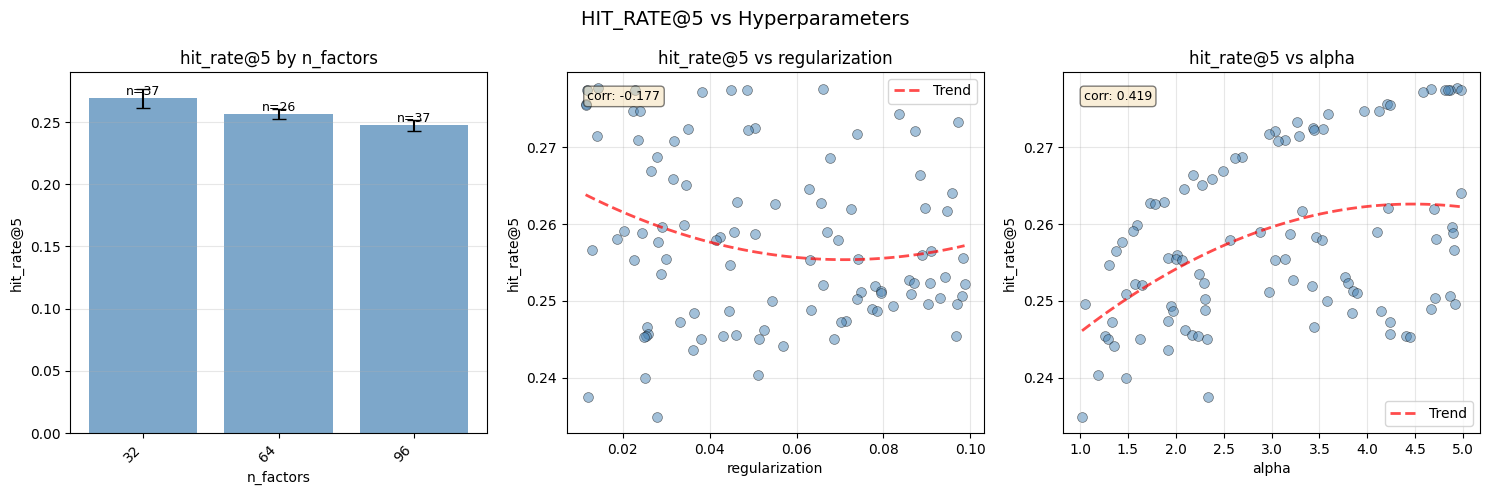

In [13]:
# Plot hyperparameter analysis
param_names = list(SEARCH_SPACE.keys())
fig = plot_hyperparameter_analysis(
    results_df,
    param_names,
    metric=METRIC,
    k=K,
    figsize=(15, 5)
)
plt.show()


In [14]:
# Re-train with best params
best_config = results_df.iloc[0]
best_params = {key: best_config[key] for key in SEARCH_SPACE.keys()}

model = ALSRecommender(**best_params)
model.fit(interaction_matrix, pilot_to_idx, site_to_idx, idx_to_site, site_id_to_name)

2025-10-18 03:38:32,844 - als - INFO - Training ALS with 32.0 factors, regularization=0.014180537144799797, iterations=20, alpha=4.932923543227153
2025-10-18 03:38:32,849 - als - INFO - Interaction matrix - shape: (13244, 252), density: 0.034168
2025-10-18 03:38:32,850 - als - INFO - Fitting implicit ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-18 03:38:34,072 - als - INFO - Learned factors - user_factors: (13244, 32), item_factors: (252, 32)
2025-10-18 03:38:34,077 - als - INFO - Site embeddings shape: (252, 32)
2025-10-18 03:38:34,082 - als - INFO - Computing site similarity matrix...
2025-10-18 03:38:34,102 - als - INFO - Similarity matrix shape: (252, 252)


## 6. Evaluate on Validation Set


In [15]:
utils.print_sample_sequence(val_sequences[100], model, top_k=10)


Pilot's history: ['Bassano', 'Mieroszów']
Actual next site: Černá hora (ID: 4)

Top 10 recommendations:
  1. Andrzejowka: 0.4910
  2. Černá hora: 0.4214 ← TARGET
  3. Srbce: 0.3919
  4. Dolní Morava: 0.3429
  5. Skrzyczne: 0.3166
  6. Ciecien: 0.3113
  7. Szczebel: 0.3104
  8. Zvičina: 0.3020
  9. Żar: 0.2919
  10. Kozákov: 0.2782


In [16]:
# Evaluate using walk-forward sequences
# Pass train_df to compute coverage and avg_log_pop metrics
val_metrics = evaluate_walk_forward(
    model,
    val_sequences,
    train_site_vocab,
    train_df=train_df,
    k_values=Ks,
    verbose=True
)


2025-10-18 03:38:40,791 - metrics - INFO - Computed popularity for 252 sites
2025-10-18 03:38:40,822 - metrics - INFO - Evaluating 21,862 valid sequences (out of 21,862)
100%|████████████████████████████████████████████████████████████████████████████| 21862/21862 [01:44<00:00, 210.13it/s]
2025-10-18 03:40:24,869 - metrics - INFO - 
2025-10-18 03:40:24,870 - metrics - INFO - Walk-Forward Evaluation Results
2025-10-18 03:40:24,871 - metrics - INFO - ============================================================
2025-10-18 03:40:24,871 - metrics - INFO - 
Metrics @ K=3:
2025-10-18 03:40:24,873 - metrics - INFO -   Hit Rate@3:  0.2046
2025-10-18 03:40:24,879 - metrics - INFO -   MRR:           0.1739
2025-10-18 03:40:24,883 - metrics - INFO -   NDCG@3:      0.1574
2025-10-18 03:40:24,886 - metrics - INFO -   Coverage@3:  0.9881 (249/252 sites)
2025-10-18 03:40:24,891 - metrics - INFO -   Avg Log-Pop@3: 5.6277
2025-10-18 03:40:24,892 - metrics - INFO - 
Metrics @ K=5:
2025-10-18 03:40:24,896

## 7. Evaluate on Test Set


In [17]:
# Evaluate on test set
# Pass train_df to compute coverage and avg_log_pop metrics
test_metrics = evaluate_walk_forward(
    model,
    test_sequences,
    train_site_vocab,
    train_df=train_df,
    k_values=Ks,
    verbose=True
)


2025-10-18 03:40:28,875 - metrics - INFO - Computed popularity for 252 sites
2025-10-18 03:40:29,008 - metrics - INFO - Evaluating 21,221 valid sequences (out of 21,221)
100%|████████████████████████████████████████████████████████████████████████████| 21221/21221 [01:40<00:00, 211.22it/s]
2025-10-18 03:42:09,483 - metrics - INFO - 
2025-10-18 03:42:09,483 - metrics - INFO - Walk-Forward Evaluation Results
2025-10-18 03:42:09,484 - metrics - INFO - ============================================================
2025-10-18 03:42:09,485 - metrics - INFO - 
Metrics @ K=3:
2025-10-18 03:42:09,489 - metrics - INFO -   Hit Rate@3:  0.2113
2025-10-18 03:42:09,493 - metrics - INFO -   MRR:           0.1821
2025-10-18 03:42:09,497 - metrics - INFO -   NDCG@3:      0.1636
2025-10-18 03:42:09,498 - metrics - INFO -   Coverage@3:  0.9881 (249/252 sites)
2025-10-18 03:42:09,504 - metrics - INFO -   Avg Log-Pop@3: 5.6381
2025-10-18 03:42:09,507 - metrics - INFO - 
Metrics @ K=5:
2025-10-18 03:42:09,511

## 8. Visualize Results


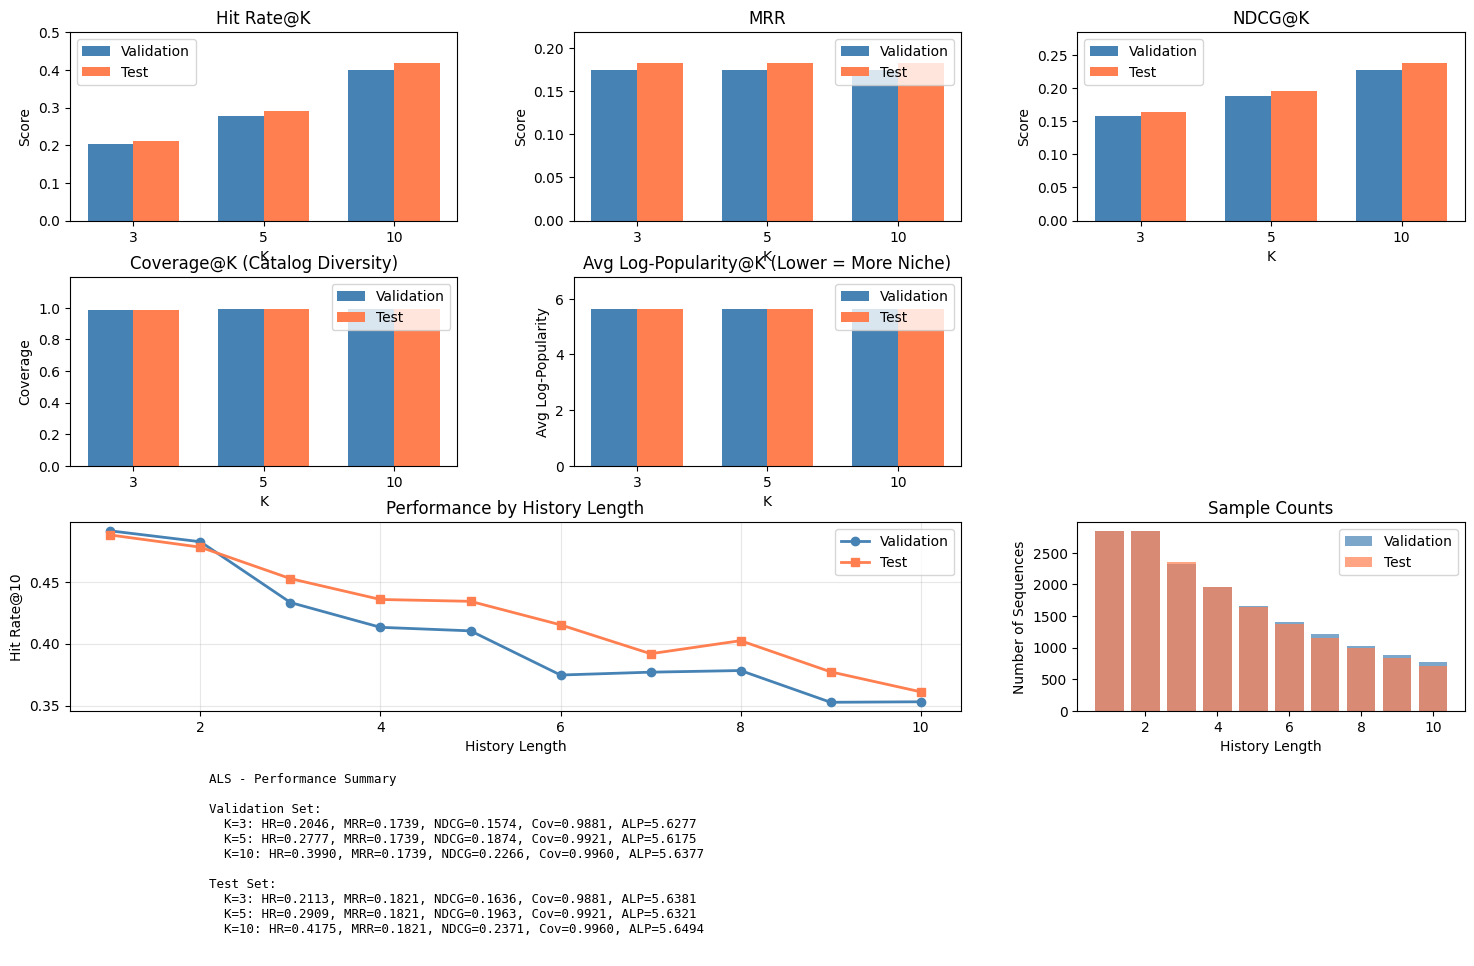

In [18]:
# Create a comprehensive dashboard with all visualizations
fig = plots.create_results_dashboard(
    val_metrics,
    test_metrics,
    model_name='ALS',
    k_values=Ks,
)
plt.show()


## 9. Save Model and Results


In [19]:
# Save the trained model
model.save('als_model_walk_forward.pkl')

# Aggregate and save metrics
results = {
    'model_type': 'ALS',
    'n_factors': model.n_factors,
    'regularization': model.regularization,
    'alpha': model.alpha,
    'val_metrics': aggregate_metrics(val_metrics),
    'test_metrics': aggregate_metrics(test_metrics),
    'n_sites': len(site_to_idx),
    'n_train_pilots': len(train_df['pilot'].unique()),
    'n_val_pilots': len(val_df['pilot'].unique()),
    'n_test_pilots': len(test_df['pilot'].unique()),
    'n_train_visits': len(train_df),
    'n_val_sequences': len(val_sequences),
    'n_test_sequences': len(test_sequences),
}

with open('als_results_walk_forward.pkl', 'wb') as f:
    pickle.dump(results, f)

print("\nModel and results saved!")
print("\nSummary:")
print(f"  Model: ALS with {model.n_factors} factors")
print(f"  Regularization: {model.regularization}")
print(f"  Alpha: {model.alpha}")
print(f"  Sites: {len(site_to_idx)}")
print(f"  Train pilots: {results['n_train_pilots']}")
print(f"  Val pilots: {results['n_val_pilots']}")
print(f"  Test pilots: {results['n_test_pilots']}")
print(f"\nValidation Performance:")
print(f"  Hit Rate@10: {results['val_metrics']['overall'][10]['hit_rate']:.4f}")
print(f"  MRR: {results['val_metrics']['overall'][10]['mrr']:.4f}")
print(f"  NDCG@10: {results['val_metrics']['overall'][10]['ndcg']:.4f}")
print(f"\nTest Performance:")
print(f"  Hit Rate@10: {results['test_metrics']['overall'][10]['hit_rate']:.4f}")
print(f"  MRR: {results['test_metrics']['overall'][10]['mrr']:.4f}")
print(f"  NDCG@10: {results['test_metrics']['overall'][10]['ndcg']:.4f}")


2025-10-18 03:42:19,059 - als - INFO - Model saved to 'als_model_walk_forward.pkl'



Model and results saved!

Summary:
  Model: ALS with 32.0 factors
  Regularization: 0.014180537144799797
  Alpha: 4.932923543227153
  Sites: 252
  Train pilots: 13244
  Val pilots: 2838
  Test pilots: 2839

Validation Performance:
  Hit Rate@10: 0.3990
  MRR: 0.1739
  NDCG@10: 0.2266

Test Performance:
  Hit Rate@10: 0.4175
  MRR: 0.1821
  NDCG@10: 0.2371


## 7. Evaluate on Test Set
